# MC-BNB / MC-Cosmic comparison to data
## A closure study - can we extract $m_A=0.99$ GeV from the distirbution of the truth-$Q^2$ using GENIE event weight?

In [18]:
import sys; sys.path.insert(0, '../../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
import json
%matplotlib inline

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/MCCosmic/'

In [3]:
versions['overlay date'] = '2018_07_24'

In [5]:
Tune1samples = load_samples(date=versions['overlay date'],filename='prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev'+'_'+versions['overlay date']+'_vertices')
print 
Tune3samples = load_samples(date=versions['overlay date'],filename='prodgenie_bnb_nu_cosmic_uboone_MCC8Tune3_mcc8.7_reco2_dev'+'_'+versions['overlay date']+'_vertices')

77177 ccqe candidate pairs, 53305 in FV
10785 are 1mu-1p, 20.2%
8496 are other pairs, 15.9%
34064 are cosmic, 63.9%
--------------------------------------------------------------
5310 are CC 1p 0pi, 10.0%
I finished loading overlay samples. We have in total 77177 pairs

154948 ccqe candidate pairs, 106279 in FV
20345 are 1mu-1p, 19.1%
19040 are other pairs, 17.9%
66992 are cosmic, 63.0%
--------------------------------------------------------------
10352 are CC 1p 0pi, 9.7%
I finished loading overlay samples. We have in total 154948 pairs


## 2. apply the event-selection cuts

In [6]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedTune1,_,_ = apply_cuts_to_overlay(OverlaySamples=Tune1samples, cuts_order=cuts_order)
print 'applied cuts to tune-1'
reducedTune3,_,_ = apply_cuts_to_overlay(OverlaySamples=Tune3samples, cuts_order=cuts_order)
print 'applied cuts to tune-3'

applied cuts to tune-1
applied cuts to tune-3


In [7]:
selected_tune1=dict()
for pair_type in pair_types:
    selected_tune1[pair_type] = reducedTune1['Pt & delta phi'][pair_type]
selected_tune1_concat = pd.concat([selected_tune1['1mu-1p'],selected_tune1['cosmic'],selected_tune1['other pairs']])    
print len(selected_tune1_concat),'events in the tune-1'

selected_tune3=dict()
for pair_type in pair_types:
    selected_tune3[pair_type] = reducedTune3['Pt & delta phi'][pair_type]
selected_tune3_concat = pd.concat([selected_tune3['1mu-1p'],selected_tune3['cosmic'],selected_tune3['other pairs']])    
print len(selected_tune3_concat),'events in the tune-3'

2295 events in the tune-1
4759 events in the tune-3


In [17]:
versions['overlay date'] = '2018_07_24'
sum_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'
summary_tune1 = pd.read_csv(sum_path+versions['overlay date']+'/prodgenie_bnb_nu_cosmic_uboone_mcc8.7_reco2_dev_'+versions['overlay date']+'_summary.csv')
POT_tune1  = np.sum(summary_tune1.POT)
summary_tune3 = pd.read_csv(sum_path+versions['overlay date']+'/prodgenie_bnb_nu_cosmic_uboone_MCC8Tune3_mcc8.7_reco2_dev_'+versions['overlay date']+'_summary.csv')
POT_tune3  = np.sum(summary_tune3.POT)
fPOT_tune1 = 5e19/POT_tune1
print 'POT_tune1:',POT_tune1,',fPOT_tune1:',fPOT_tune1
fPOT_tune3 = 5e19/POT_tune3
print 'POT_tune3:',POT_tune3,',fPOT_tune3:',fPOT_tune3

POT_tune1: 2.01905701e+20 ,fPOT_tune1: 0.247640357614
POT_tune3: 4.31667174e+20 ,fPOT_tune3: 0.115829979696


## tune-1 vs. tune-3

In [9]:
mA_array = [0.7,0.99,1.3]
# mA_array = np.concatenate([[0.4],linspace(0.55,1.2,13),[1.3,1.35,1.5,1.6,1.7]])
# [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
# mA_names = ['040','070','080','095','099','100','110','115','135','171']

### truth-$Q^2$

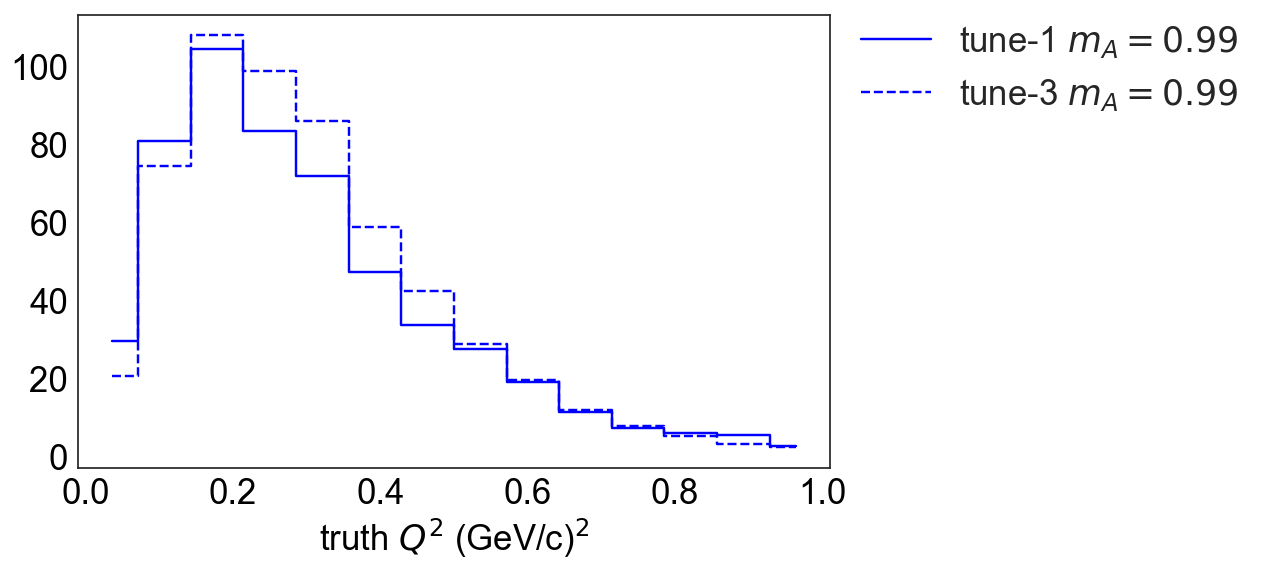

In [10]:
fig,ax=plt.subplots(figsize=(9.708,6))
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
for mA,color in zip( [0.99],['blue']): #(mA_array,['red','blue','black']):
    name = '%.0f'%(mA*100)    
    for sam,label,linestyle,fPOT in zip([selected_tune1_concat,selected_tune3_concat]
                                        ,['tune-1','tune-3']
                                        ,['-','--']
                                        ,[fPOT_tune1,fPOT_tune3]):
        h,_ = np.histogram(sam['truth_Q2'],weights=sam['evwgh_mA'+name+'_Genie'],bins=bins)
        h = h*fPOT
        plt.step(mid,h,color=color,label=label+r' $m_A=%.2f$'%mA,linestyle=linestyle,where='mid')
set_axes(ax,r'truth $Q^2$ (GeV/c)$^2$','',do_add_legend=False)
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

### reco-$Q^2$

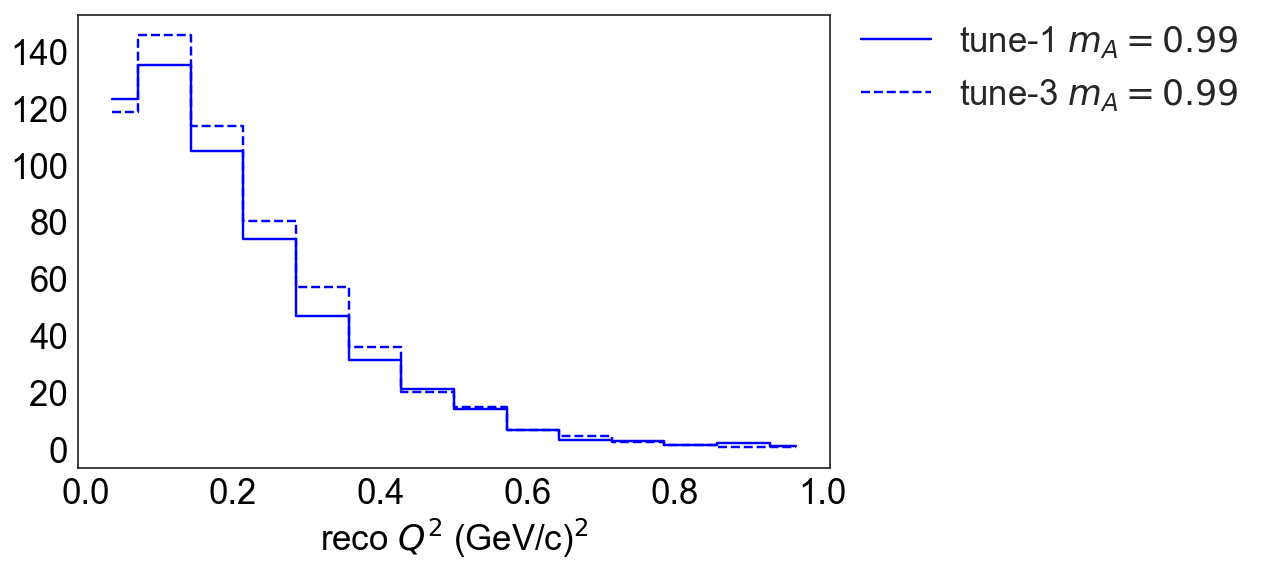

In [11]:
fig,ax=plt.subplots(figsize=(9.708,6))
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
for mA,color in zip( [0.99],['blue']): #(mA_array,['red','blue','black']):
    name = '%.0f'%(mA*100)    
    for sam,label,linestyle,fPOT in zip([selected_tune1_concat,selected_tune3_concat]
                                        ,['tune-1','tune-3']
                                        ,['-','--']
                                        ,[fPOT_tune1,fPOT_tune3]):
        h,_ = np.histogram(sam['reco_Q2'],weights=sam['evwgh_mA'+name+'_Genie'],bins=bins)
        h = h*fPOT
        plt.step(mid,h,color=color,label=label+r' $m_A=%.2f$'%mA,linestyle=linestyle,where='mid')
set_axes(ax,r'reco $Q^2$ (GeV/c)$^2$','',do_add_legend=False)
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

### compare with MC/cosmic data overlay and with the beam-on data

In [13]:
versions['overlay date'] = '2018_07_19'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [21]:
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = path+versions['Overlay']+'_'+versions['overlay date']+'_'
selected_overlay=dict()

if os.path.isfile(prefix+'selected_cc1p0pi.csv'): 
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')
    selected_CC1p0pi=pd.read_csv(prefix+'selected_cc1p0pi.csv')
    overlay_scaling = json.load(open(prefix+"overlay_scaling_POT.txt"))


else:
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
    selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
    print len(selected_overlay_concat),'events in the overlay'
    selected_cc1p0pi = selected_overlay['CC 1p 0pi']
    print len(selected_cc1p0pi),'selected CC 1p 0pi pairs in overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type].to_csv(prefix+'selected_'+pair_type+'.csv')
    selected_cc1p0pi.to_csv(prefix+'selected_cc1p0pi.csv')
    print 'output to ',figures_path,'.csv'
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']
    overlay_scaling = get_samples_scaling( N_total='MC(tot) x POT', debug=0, OverlaySubsamples=OverlaySamples, f_POT=Nevents['f(POT)'])
    filename = prefix+"overlay_scaling_POT.txt"
    json.dump(overlay_scaling, open(filename,'w'))
    print 'saved scaling into',filename

In [22]:
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')

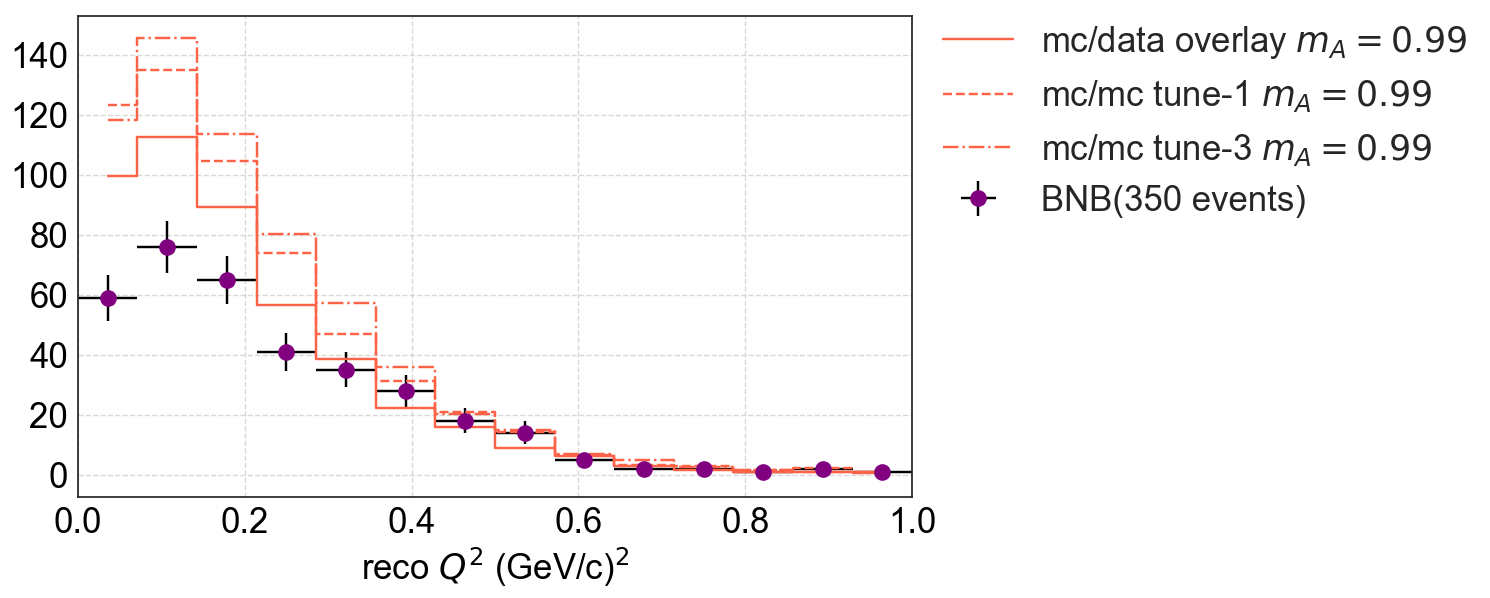

In [38]:
fig,ax=plt.subplots(figsize=(9.708,6))
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
for mA,color in zip( [0.99],['tomato']): #(mA_array,['red','blue','black']):
    name = '%.0f'%(mA*100)    
    for sam,label,linestyle,fPOT in zip([selected_overlay_concat,selected_tune1_concat,selected_tune3_concat]
                                        ,['mc/data overlay','mc/mc tune-1','mc/mc tune-3']
                                        ,['-','--','-.']
                                        ,[Nevents['f(POT)'],fPOT_tune1,fPOT_tune3]):
        h,_ = np.histogram(sam['reco_Q2'],weights=sam['evwgh_mA'+name+'_Genie'],bins=bins)
        h = h*fPOT
        plt.step(mid,h,color=color,label=label+r' $m_A=%.2f$'%mA,linestyle=linestyle,where='mid')

plot_OnBeam(OnBeamSample=selected_events,var='reco_Q2',color='purple',bins=bins,ax=ax)
set_axes(ax,r'reco $Q^2$ (GeV/c)$^2$','',do_add_legend=False,xlim=(0,1))
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

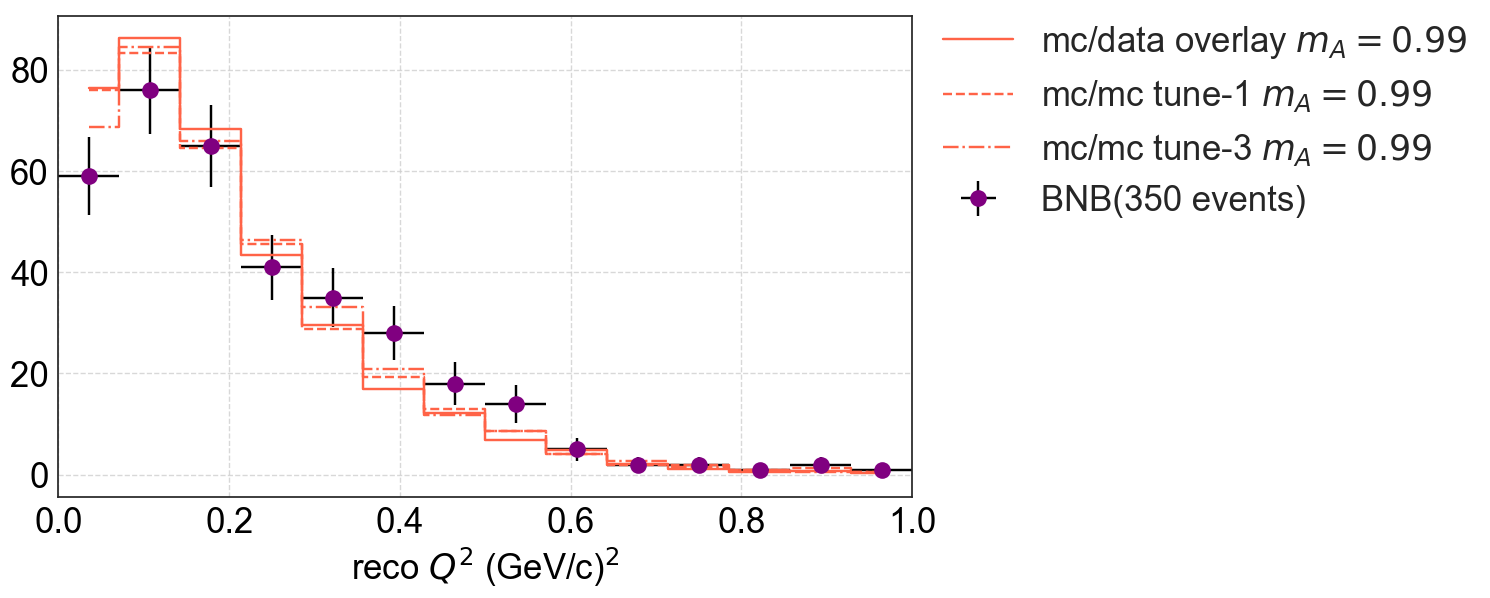

In [40]:
# shape-comparison
fig,ax=plt.subplots(figsize=(9.708,6))
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
for mA,color in zip( [0.99],['tomato']): #(mA_array,['red','blue','black']):
    name = '%.0f'%(mA*100)    
    for sam,label,linestyle,fPOT in zip([selected_overlay_concat,selected_tune1_concat,selected_tune3_concat]
                                        ,['mc/data overlay','mc/mc tune-1','mc/mc tune-3']
                                        ,['-','--','-.']
                                        ,[Nevents['f(POT)'],fPOT_tune1,fPOT_tune3]):
        h,_ = np.histogram(sam['reco_Q2'],weights=sam['evwgh_mA'+name+'_Genie'],bins=bins)
        h = h*350./np.sum(h)
        plt.step(mid,h,color=color,label=label+r' $m_A=%.2f$'%mA,linestyle=linestyle,where='mid')

plot_OnBeam(OnBeamSample=selected_events,var='reco_Q2',color='purple',bins=bins,ax=ax)
set_axes(ax,r'reco $Q^2$ (GeV/c)$^2$','',do_add_legend=False,xlim=(0,1))
plt.legend(bbox_to_anchor=(1,1.05),loc=2,fontsize=25)

# It seems that tune-3 has a better shape-correspondence with the data. What if we take different $m_A$'s?

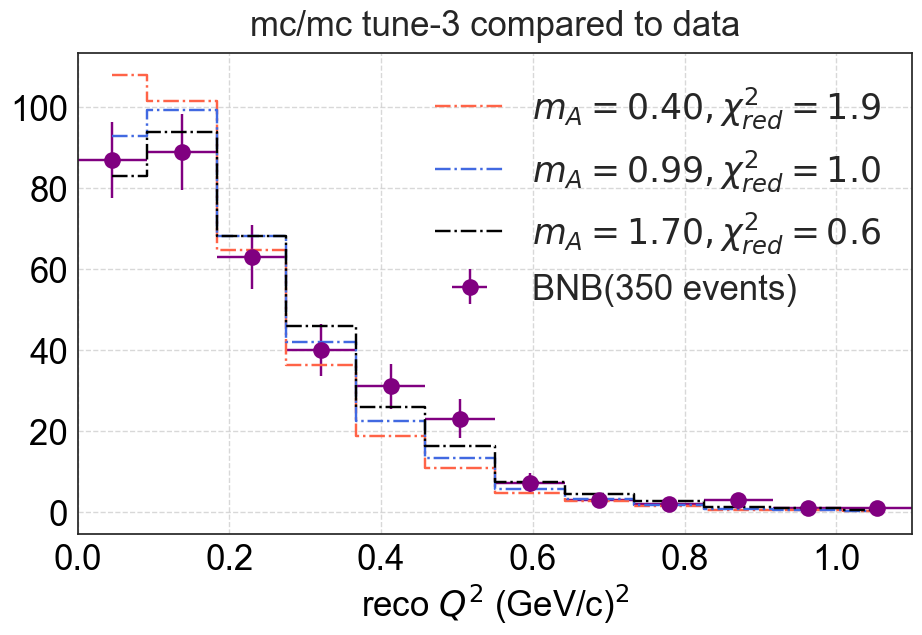

In [71]:
# shape-comparison
fig,ax=plt.subplots(figsize=(9.708,6))
Q2min,Q2max,nbins = 0.0,1.1,13
bins = linspace(Q2min,Q2max,nbins); mid = 0.5*(bins[1:]+bins[:-1])
data = selected_events[(Q2min<selected_events['reco_Q2'])&(selected_events['reco_Q2']<Q2max)]
N = float(len(data))

hdata,hdata_err = plot_OnBeam(OnBeamSample=data,var='reco_Q2',color='purple',bins=bins,ax=ax,ecolor='purple',do_return_h=True)
sam = selected_tune3_concat
for mA,color in zip([0.4,0.99,1.7],['tomato','royalblue','black']):
    name = '%.0f'%(mA*100)
    hsim,_ = np.histogram(sam['reco_Q2'],weights=sam['evwgh_mA'+name+'_Genie'],bins=bins)
    hsim_err = np.sqrt(hsim)*N/np.sum(hsim)
    hsim = hsim*N/np.sum(hsim)    
    chi2,ndf = chi2_two_histograms(bins=bins,chi2_xrange=(Q2min,Q2max)
                                   ,h1=hdata,h2=hsim
                                   ,h1err=hdata_err,h2err=hsim_err)
    plt.step(mid,hsim,color=color,label=r'$m_A=%.2f, \chi^2_{red}=%.1f$'%(mA,chi2/ndf),linestyle=linestyle,where='mid')
set_axes(ax,r'reco $Q^2$ (GeV/c)$^2$','',do_add_legend=True,xlim=(Q2min,Q2max),title='mc/mc tune-3 compared to data')